In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images-shoes/train_B.npz
/kaggle/input/images-shoes/test.npz
/kaggle/input/images-shoes/train_A.npz


In [2]:
import os, random, numpy as np
import torch
from torchvision import models
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import gc
import pickle
from pathlib import Path

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [5]:
def make_folds(n, k=10, seed=42, y=None):
    """
    Create stratified k-fold splits that preserve class distribution.
    
    Parameters:
    - n: Total number of samples
    - k: Number of folds (default=10)
    - seed: Random seed for reproducibility (default=42)
    - y: Labels for stratification (required)
    
    Returns:
    - List of k arrays containing indices for each fold
    """
    np.random.seed(seed)
    
    unique_classes = np.unique(y)
    folds = [[] for _ in range(k)]
    
    # For each class, split its samples across k folds
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        cls_splits = np.array_split(cls_indices, k)
        
        # Add class samples to each fold
        for fold_idx, split in enumerate(cls_splits):
            folds[fold_idx].extend(split)
    
    # Shuffle within each fold and convert to numpy arrays
    for i in range(k):
        np.random.shuffle(folds[i])
        folds[i] = np.array(folds[i])
    
    return folds

In [10]:
def confusion_matrix_manual(y_true, y_pred, labels):
    n = len(labels)
    label_to_idx = {lab: i for i, lab in enumerate(labels)}
    cm = np.zeros((n, n), dtype=int)
    for yt, yp in zip(y_true, y_pred):
        i = label_to_idx[yt]
        j = label_to_idx[yp]
        cm[i, j] += 1
    return cm

In [11]:
def calc_metrics(cm):
    TP = np.diag(cm)
    FP = cm.sum(0) - TP
    FN = cm.sum(1) - TP
    precision = np.mean(TP / (TP + FP + 1e-9))
    recall    = np.mean(TP / (TP + FN + 1e-9))
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    acc = TP.sum() / cm.sum()
    return acc, precision, recall, f1

In [9]:
def train_one_fold(X_train, y_train, X_val, y_val, model_builder,
                   lr=1e-3, epochs=5, batch=64, device="cpu"):
    """Train one fold and return model + predictions on validation set."""
    
    train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_ds   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
    train_dl = DataLoader(train_ds, batch_size=batch, shuffle=True)
    val_dl   = DataLoader(val_ds, batch_size=batch, shuffle=False)

    # note: difference here — build model dynamically
    model = model_builder().to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dl)
        print(f"  Epoch {ep+1}/{epochs}, Train loss={avg_loss:.4f}")

    # ----- validation predictions -----
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in val_dl:
            xb = xb.to(device)
            probs = torch.softmax(model(xb), 1)
            preds.append(torch.argmax(probs, 1).cpu().numpy())
    preds = np.concatenate(preds)
    
    #memory cleanup
    del model, loss_fn, opt, train_dl, val_dl
    if device == "cuda":
        torch.cuda.empty_cache()
    gc.collect()
    return None, preds

In [10]:
def evaluate_model_nested_cv(
    X, y, model_builder,
    candidate_lr=[1e-3, 3e-4, 1e-4],
    k_outer=10, k_inner=3, epochs=5,
    device="cpu"
):
    """Generic nested cross‑validation for any model."""

    folds = make_folds(len(X), k_outer, seed=42, y=y)
    metrics_all = []

    for i in range(k_outer):
        print(f"\n=== Outer Fold {i+1}/{k_outer} ===")

        test_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k_outer) if j != i])
        X_train, y_train = X[train_idx], y[train_idx]
        X_test,  y_test  = X[test_idx],  y[test_idx]

        # ---- inner loop: tuning learning rate ----
        inner_folds = make_folds(len(X_train), k_inner, seed=42, y=y_train)
        mean_accs = []

        for lr in candidate_lr:
            inner_scores = []
            for j in range(k_inner):
                val_idx = inner_folds[j]
                tr_idx  = np.concatenate([inner_folds[m] for m in range(k_inner) if m != j])

                _, y_pred_val = train_one_fold(
                    X_train[tr_idx], y_train[tr_idx],
                    X_train[val_idx], y_train[val_idx],
                    model_builder=model_builder,
                    lr=lr, epochs=2, device=device
                )

                cm = confusion_matrix_manual(y_train[val_idx], y_pred_val, labels=np.unique(y))
                acc, prec, rec, f1 = calc_metrics(cm)
                inner_scores.append(acc)

            mean_accs.append(np.mean(inner_scores))

        best_lr = candidate_lr[int(np.argmax(mean_accs))]
        print(f"Best LR = {best_lr:.0e}")

        # ---- outer test fold ----
        _, y_pred = train_one_fold(
            X_train, y_train, X_test, y_test,
            model_builder=model_builder,
            lr=best_lr, epochs=epochs, device=device
        )

        cm = confusion_matrix_manual(y_test, y_pred, labels=np.unique(y))
        acc, prec, rec, f1 = calc_metrics(cm)
        metrics_all.append([acc, prec, rec, f1])

        print(f"Fold {i+1}: Acc={acc:.3f}, P={prec:.3f}, R={rec:.3f}, F1={f1:.3f}")
        
        #memory cleanup
        if device == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

    # ---- summary ----
    metrics_all = np.array(metrics_all)
    mean, std = metrics_all.mean(0), metrics_all.std(0)

    print("\n=== Nested CV Results ===")
    print(f"Accuracy : {mean[0]:.3f} ± {std[0]:.3f}")
    print(f"Precision: {mean[1]:.3f} ± {std[1]:.3f}")
    print(f"Recall   : {mean[2]:.3f} ± {std[2]:.3f}")
    print(f"F1-score : {mean[3]:.3f} ± {std[3]:.3f}")

    return mean, std

In [14]:
class DeepCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # 32 filters
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                 # Downsample

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )

        self.flatten_dim = None
        self.classifier = None
        self.n_classes = n_classes

    def _get_flatten_dim(self, x):
        with torch.no_grad():
            f = self.features(x)
            return f.view(f.size(0), -1).shape[1]

    def forward(self, x):
        if self.classifier is None:
            flat_dim = self._get_flatten_dim(x)
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(flat_dim, 128), nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128, self.n_classes)
            ).to(x.device)
        out = self.features(x)
        out = self.classifier(out)
        return out

Training on train_B.npz (dirty images)

In [18]:
data_dir = "/kaggle/input/images-shoes"
data = np.load(os.path.join(data_dir, "train_B.npz"))  # or train_A.npz
X, y = data["X"], data["y"]
print("Loaded:", X.shape, y.shape)

# ---------- encode string labels to ints ----------
encoder = LabelEncoder()
y = encoder.fit_transform(y)            # e.g. Boot→0, Sandal→1, Shoe→2

#save encoder
with open('/kaggle/working/encoder_trainB.pkl', 'wb') as f:
    pickle.dump(encoder, f)

print("Label mapping:", dict(zip(encoder.classes_,
                                 range(len(encoder.classes_)))))

# ---------- normalise images ----------
X = X.astype("float32") / 255.0

# ---------- reshape for PyTorch (N,C,H,W) ----------
X = np.transpose(X, (0,3,1,2))
y = y.astype("int64")
num_classes = len(np.unique(y))
print("Final tensors:", X.shape, "Classes:", num_classes)

Loaded: (12000, 224, 224, 3) (12000,)
Label mapping: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}
Final tensors: (12000, 3, 224, 224) Classes: 3


In [21]:
# --- DeepCNN ---
print("\n### Evaluating DeepCNN ###")
deep_mean_B, deep_std_B = evaluate_model_nested_cv(
    X, y,
    model_builder=lambda: DeepCNN(num_classes),
    candidate_lr=[3e-3, 1e-3, 3e-4],
    k_outer=10,
    k_inner=3,
    epochs=3,
    device=device
)

#saving results
import pickle

cv_results_B = {
    'mean': deep_mean_B,
    'std': deep_std_B,
    'accuracy': deep_mean_B[0],
    'precision': deep_mean_B[1],
    'recall': deep_mean_B[2],
    'f1': deep_mean_B[3]
}

with open('/kaggle/working/cv_results_trainB.pkl', 'wb') as f:
    pickle.dump(cv_results_B, f)

print("CV results saved!")


### Evaluating DeepCNN ###

=== Outer Fold 1/10 ===
  Epoch 1/2, Train loss=0.9186
  Epoch 2/2, Train loss=0.7659
  Epoch 1/2, Train loss=0.9090
  Epoch 2/2, Train loss=0.7549
  Epoch 1/2, Train loss=0.9340
  Epoch 2/2, Train loss=0.7718
  Epoch 1/2, Train loss=0.9266
  Epoch 2/2, Train loss=0.7782
  Epoch 1/2, Train loss=0.9270
  Epoch 2/2, Train loss=0.7841
  Epoch 1/2, Train loss=0.9262
  Epoch 2/2, Train loss=0.7785
  Epoch 1/2, Train loss=0.9811
  Epoch 2/2, Train loss=0.8617
  Epoch 1/2, Train loss=0.9634
  Epoch 2/2, Train loss=0.8492
  Epoch 1/2, Train loss=0.9903
  Epoch 2/2, Train loss=0.8747
Best LR = 1e-03
  Epoch 1/3, Train loss=0.8735
  Epoch 2/3, Train loss=0.7241
  Epoch 3/3, Train loss=0.6613
Fold 1: Acc=0.816, P=0.819, R=0.816, F1=0.817

=== Outer Fold 2/10 ===
  Epoch 1/2, Train loss=0.9078
  Epoch 2/2, Train loss=0.7662
  Epoch 1/2, Train loss=0.9118
  Epoch 2/2, Train loss=0.7604
  Epoch 1/2, Train loss=0.9299
  Epoch 2/2, Train loss=0.7572
  Epoch 1/2, Train loss

Training Final Model

In [15]:
def train_final_model(X, y, model_builder, lr=1e-3, epochs=5, batch=64, device="cpu"):
    """Train final model on full dataset (no validation split)."""
    
    train_ds = TensorDataset(torch.tensor(X), torch.tensor(y))
    train_dl = DataLoader(train_ds, batch_size=batch, shuffle=True)
    
    model = model_builder().to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    
    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dl)
        print(f"  Epoch {ep+1}/{epochs}, Train loss={avg_loss:.4f}")
    
    return model

In [19]:
# After nested CV
print("\n=== Training Final Model on Full Dataset (Dirty Images) ===")

final_model = train_final_model(
    X, y,
    model_builder=lambda: DeepCNN(num_classes),
    lr=1e-3,
    epochs=5,
    batch=64,
    device=device
)

torch.save(final_model.state_dict(), '/kaggle/working/deepcnn_final_B.pth')
print("Final model saved!")


=== Training Final Model on Full Dataset (Dirty Images) ===
  Epoch 1/5, Train loss=0.8796
  Epoch 2/5, Train loss=0.7210
  Epoch 3/5, Train loss=0.6518
  Epoch 4/5, Train loss=0.6117
  Epoch 5/5, Train loss=0.5837
Final model saved!


Testing Model

In [17]:
# ===== LOAD AND PREPARE TEST DATA =====
print("\n=== Loading Test Data ===")
test_data = np.load(os.path.join(data_dir, "test.npz"))
X_test, y_test = test_data["X"], test_data["y"]
print("Loaded test data:", X_test.shape, y_test.shape)

#loading correct encoder
with open('/kaggle/working/encoder_trainB.pkl', 'rb') as f:
    encoder = pickle.load(f)

# Encode labels (same encoder from training)
y_test = encoder.transform(y_test)

# Normalize images
X_test = X_test.astype("float32") / 255.0

# Reshape for PyTorch (N,C,H,W)
X_test = np.transpose(X_test, (0,3,1,2))
y_test = y_test.astype("int64")

print("Test data prepared:", X_test.shape)

# ===== MAKE PREDICTIONS =====
print("\n=== Evaluating Final Model on Test Set ===")

test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

final_model.eval()
y_pred_test = []

with torch.no_grad():
    for xb, _ in test_dl:
        xb = xb.to(device)
        probs = torch.softmax(final_model(xb), 1)
        y_pred_test.append(torch.argmax(probs, 1).cpu().numpy())

y_pred_test = np.concatenate(y_pred_test)

# ===== CALCULATE METRICS =====
cm_test = confusion_matrix_manual(y_test, y_pred_test, labels=np.unique(y_test))
acc_test, prec_test, rec_test, f1_test = calc_metrics(cm_test)

print(f"\n=== Test Set Results ===")
print(f"Accuracy : {acc_test:.3f}")
print(f"Precision: {prec_test:.3f}")
print(f"Recall   : {rec_test:.3f}")
print(f"F1-score : {f1_test:.3f}")

print(f"\nConfusion Matrix:")
print(cm_test)
print(f"Classes: {encoder.classes_}")

# ===== COMPARISON WITH CV =====
with open('/kaggle/working/cv_results_trainB.pkl', 'rb') as f:
    cv_results_B = pickle.load(f)

# Extract the variables you need
deep_mean_B = cv_results_B['mean']
deep_std_B = cv_results_B['std']

print(f"\n=== Performance Comparison ===")
print(f"CV Performance:   {deep_mean_B[0]:.3f} ± {deep_std_B[0]:.3f}")  # ✅ Use index [0] for accuracy
print(f"Test Performance: {acc_test:.3f}")
print(f"Difference:       {acc_test - deep_mean_B[0]:.3f}")  # ✅ Use index [0]


=== Loading Test Data ===
Loaded test data: (3000, 224, 224, 3) (3000,)
Test data prepared: (3000, 3, 224, 224)

=== Evaluating Final Model on Test Set ===

=== Test Set Results ===
Accuracy : 0.843
Precision: 0.842
Recall   : 0.843
F1-score : 0.842

Confusion Matrix:
[[946  30  24]
 [108 757 135]
 [ 46 128 826]]
Classes: ['Boot' 'Sandal' 'Shoe']

=== Performance Comparison ===
CV Performance:   0.799 ± 0.020
Test Performance: 0.843
Difference:       0.044


### Repeating the above, but this time using train_A (which is the image set with only clean images)

In [12]:
data_dir = "/kaggle/input/images-shoes"
data = np.load(os.path.join(data_dir, "train_A.npz"))  #changed to train_A.npz
X, y = data["X"], data["y"]
print("Loaded:", X.shape, y.shape)

# ---------- encode string labels to ints ----------
encoder = LabelEncoder()
y = encoder.fit_transform(y)            # e.g. Boot→0, Sandal→1, Shoe→2

#save encoder
with open('/kaggle/working/encoder_trainA.pkl', 'wb') as f:
    pickle.dump(encoder, f)
    
print("Label mapping:", dict(zip(encoder.classes_,
                                 range(len(encoder.classes_)))))

# ---------- normalise images ----------
X = X.astype("float32") / 255.0

# ---------- reshape for PyTorch (N,C,H,W) ----------
X = np.transpose(X, (0,3,1,2))
y = y.astype("int64")
num_classes = len(np.unique(y))
print("Final tensors:", X.shape, "Classes:", num_classes)

Loaded: (12000, 224, 224, 3) (12000,)
Label mapping: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}
Final tensors: (12000, 3, 224, 224) Classes: 3


In [13]:
# --- DeepCNN --- 
print("\n### Evaluating DeepCNN ###")
deep_mean_A, deep_std_A = evaluate_model_nested_cv(
    X, y,
    model_builder=lambda: DeepCNN(num_classes),
    candidate_lr=[3e-3, 1e-3, 3e-4],
    k_outer=10,
    k_inner=3,
    epochs=3,
    device=device
)

import pickle

cv_results_A = {
    'mean': deep_mean_A,
    'std': deep_std_A,
    'accuracy': deep_mean_A[0],
    'precision': deep_mean_A[1],
    'recall': deep_mean_A[2],
    'f1': deep_mean_A[3]
}

with open('/kaggle/working/cv_results_trainA.pkl', 'wb') as f:
    pickle.dump(cv_results_A, f)

print("CV results saved!")


### Evaluating DeepCNN ###

=== Outer Fold 1/10 ===
  Epoch 1/2, Train loss=0.7664
  Epoch 2/2, Train loss=0.5608
  Epoch 1/2, Train loss=0.7626
  Epoch 2/2, Train loss=0.5600
  Epoch 1/2, Train loss=0.7324
  Epoch 2/2, Train loss=0.5504
  Epoch 1/2, Train loss=0.7799
  Epoch 2/2, Train loss=0.6029
  Epoch 1/2, Train loss=0.7233
  Epoch 2/2, Train loss=0.5521
  Epoch 1/2, Train loss=0.7769
  Epoch 2/2, Train loss=0.5930
  Epoch 1/2, Train loss=0.8542
  Epoch 2/2, Train loss=0.6773
  Epoch 1/2, Train loss=0.8415
  Epoch 2/2, Train loss=0.6645
  Epoch 1/2, Train loss=0.8234
  Epoch 2/2, Train loss=0.6538
Best LR = 1e-03
  Epoch 1/3, Train loss=0.7051
  Epoch 2/3, Train loss=0.5408
  Epoch 3/3, Train loss=0.4639
Fold 1: Acc=0.900, P=0.900, R=0.900, F1=0.900

=== Outer Fold 2/10 ===
  Epoch 1/2, Train loss=0.7760
  Epoch 2/2, Train loss=0.5782
  Epoch 1/2, Train loss=0.7593
  Epoch 2/2, Train loss=0.5623
  Epoch 1/2, Train loss=0.7432
  Epoch 2/2, Train loss=0.5540
  Epoch 1/2, Train loss

In [16]:
# After nested CV
print("\n=== Training Final Model on Full Dataset (Clean Images) ===")

final_model_clean = train_final_model(
    X, y,
    model_builder=lambda: DeepCNN(num_classes),
    lr=1e-3,
    epochs=5,
    batch=64,
    device=device
)

torch.save(final_model_clean.state_dict(), '/kaggle/working/deepcnn_final_clean.pth')
print("Final model saved!")


=== Training Final Model on Full Dataset (Clean Images) ===
  Epoch 1/5, Train loss=0.6687
  Epoch 2/5, Train loss=0.4961
  Epoch 3/5, Train loss=0.4271
  Epoch 4/5, Train loss=0.3816
  Epoch 5/5, Train loss=0.3456
Final model saved!


In [17]:
# ===== LOAD AND PREPARE TEST DATA =====
print("\n=== Loading Test Data (for Train_A Model) ===")
test_data = np.load(os.path.join(data_dir, "test.npz"))
X_test, y_test = test_data["X"], test_data["y"]
print("Loaded test data:", X_test.shape, y_test.shape)

#loading correct encoder
with open('/kaggle/working/encoder_trainA.pkl', 'rb') as f:
    encoder = pickle.load(f)
    
# Encode labels
y_test = encoder.transform(y_test)  # Make sure this is the encoder fitted on train_A

# Normalize images
X_test = X_test.astype("float32") / 255.0

# Reshape for PyTorch (N,C,H,W)
X_test = np.transpose(X_test, (0,3,1,2))
y_test = y_test.astype("int64")

print("Test data prepared:", X_test.shape)

# ===== MAKE PREDICTIONS =====
print("\n=== Evaluating Train_A Model on Test Set ===")

test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

final_model_clean.eval()  # ← CHANGED: Use train_A model
y_pred_test = []

with torch.no_grad():
    for xb, _ in test_dl:
        xb = xb.to(device)
        probs = torch.softmax(final_model_clean(xb), 1)  # ← CHANGED
        y_pred_test.append(torch.argmax(probs, 1).cpu().numpy())

y_pred_test = np.concatenate(y_pred_test)

# ===== CALCULATE METRICS =====
cm_test = confusion_matrix_manual(y_test, y_pred_test, labels=np.unique(y_test))
acc_test, prec_test, rec_test, f1_test = calc_metrics(cm_test)

print(f"\n=== Test Set Results (Train_A Model - Clean Training) ===")
print(f"Accuracy : {acc_test:.3f}")
print(f"Precision: {prec_test:.3f}")
print(f"Recall   : {rec_test:.3f}")
print(f"F1-score : {f1_test:.3f}")

print(f"\nConfusion Matrix:")
print(cm_test)
print(f"Classes: {encoder.classes_}")

# ===== COMPARISON WITH CV =====

# Load the saved CV results
with open('/kaggle/working/cv_results_trainA.pkl', 'rb') as f:
    cv_results_A = pickle.load(f)

# Extract the variables you need
deep_mean_A = cv_results_A['mean']
deep_std_A = cv_results_A['std']

print(f"\n=== Performance Comparison (Train_A) ===")
print(f"CV Performance:   {deep_mean_A[0]:.3f} ± {deep_std_A[0]:.3f}")  # ← Use train_A CV results
print(f"Test Performance: {acc_test:.3f}")
print(f"Difference:       {acc_test - deep_mean_A[0]:.3f}")


=== Loading Test Data (for Train_A Model) ===
Loaded test data: (3000, 224, 224, 3) (3000,)
Test data prepared: (3000, 3, 224, 224)

=== Evaluating Train_A Model on Test Set ===

=== Test Set Results (Train_A Model - Clean Training) ===
Accuracy : 0.812
Precision: 0.816
Recall   : 0.812
F1-score : 0.814

Confusion Matrix:
[[844  92  64]
 [ 70 830 100]
 [ 52 185 763]]
Classes: ['Boot' 'Sandal' 'Shoe']

=== Performance Comparison (Train_A) ===
CV Performance:   0.890 ± 0.016
Test Performance: 0.812
Difference:       -0.078


Bootstrapping, to get error bars for the test accuracy

In [12]:
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, confidence=0.95):
    n_samples = len(y_true)
    results = {"acc": [], "prec": [], "rec": [], "f1": []}
    labels = np.unique(y_true)

    for _ in range(n_bootstrap):
        idx = np.random.choice(n_samples, n_samples, replace=True)
        y_t, y_p = y_true[idx], y_pred[idx]
        cm = confusion_matrix_manual(y_t, y_p, labels=labels)
        acc, prec, rec, f1 = calc_metrics(cm)
        results["acc"].append(acc)
        results["prec"].append(prec)
        results["rec"].append(rec)
        results["f1"].append(f1)

    alpha = (1 - confidence) / 2
    stats = {}
    for k, v in results.items():
        v = np.array(v)
        stats[k] = (
            np.mean(v),
            np.percentile(v, 100 * alpha),
            np.percentile(v, 100 * (1 - alpha)),
        )
    return stats

In [16]:
# ===== PATHS =====
results_dir = "/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/COMP90051_A2/A2_DeepCNN_Results"
data_dir = "/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/augmented_data"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== LOAD TEST DATA (ONCE) =====
test_data = np.load(os.path.join(data_dir, "test.npz"))
X_test_raw, y_test_raw = test_data["X"], test_data["y"]

# ===== LOAD AND PREDICT FOR TRAIN_A MODEL (Clean Images) =====
print("\n=== Loading Train_A Model (Clean Images) ===")

# Load encoder
with open(os.path.join(results_dir, 'encoder_trainA.pkl'), 'rb') as f:
    encoder_A = pickle.load(f)

# Transform labels
y_test = encoder_A.transform(y_test_raw)

# Preprocess images
X_test = X_test_raw.astype("float32") / 255.0
X_test = np.transpose(X_test, (0, 3, 1, 2))
y_test = y_test.astype("int64")

# Load Train_A model
num_classes = len(encoder_A.classes_)
final_model_A = DeepCNN(num_classes).to(device)

# Dummy forward pass to initialize
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    _ = final_model_A(dummy_input)

# Load weights
final_model_A.load_state_dict(torch.load(os.path.join(results_dir, 'deepcnn_final_clean.pth'), map_location=device))

# Get predictions for Train_A
test_ds_A = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_dl_A = DataLoader(test_ds_A, batch_size=64, shuffle=False)

final_model_A.eval()
y_pred_test = []

with torch.no_grad():
    for xb, _ in test_dl_A:
        xb = xb.to(device)
        probs = torch.softmax(final_model_A(xb), 1)
        y_pred_test.append(torch.argmax(probs, 1).cpu().numpy())

y_pred_test = np.concatenate(y_pred_test)

# ===== BOOTSTRAP FOR TRAIN_A MODEL (Clean Images) =====
print("\n=== Bootstrap Analysis for Train_A Model ===")

stats_A = bootstrap_metrics(y_test, y_pred_test, n_bootstrap=1000)

# Extract all metrics
mean_acc_A, lower_acc_A, upper_acc_A = stats_A['acc']
mean_prec_A, lower_prec_A, upper_prec_A = stats_A['prec']
mean_rec_A, lower_rec_A, upper_rec_A = stats_A['rec']
mean_f1_A, lower_f1_A, upper_f1_A = stats_A['f1']

print(f"Test Accuracy:  {mean_acc_A:.4f} ({lower_acc_A:.4f}, {upper_acc_A:.4f})")
print(f"Test Precision: {mean_prec_A:.4f} ({lower_prec_A:.4f}, {upper_prec_A:.4f})")
print(f"Test Recall:    {mean_rec_A:.4f} ({lower_rec_A:.4f}, {upper_rec_A:.4f})")
print(f"Test F1:        {mean_f1_A:.4f} ({lower_f1_A:.4f}, {upper_f1_A:.4f})")

# ===== NOW FOR TRAIN_B MODEL (Dirty Images) =====
print("\n=== Bootstrap Analysis for Train_B Model ===")

# Load encoder for Train_B
with open(os.path.join(results_dir, 'encoder_trainB.pkl'), 'rb') as f:
    encoder_B = pickle.load(f)

# Transform labels for Train_B
y_test_B = encoder_B.transform(y_test_raw)

# Preprocess images for Train_B
X_test_B = X_test_raw.astype("float32") / 255.0
X_test_B = np.transpose(X_test_B, (0, 3, 1, 2))
y_test_B = y_test_B.astype("int64")

# Load the Train_B model
num_classes_B = len(encoder_B.classes_)
final_model_B = DeepCNN(num_classes_B).to(device)

# CRITICAL FIX: Do a dummy forward pass to initialize the classifier
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    _ = final_model_B(dummy_input)

# NOW load the weights
final_model_B.load_state_dict(torch.load(os.path.join(results_dir, 'deepcnn_final_B.pth'), map_location=device))

# Get predictions
test_ds_B = TensorDataset(torch.tensor(X_test_B), torch.tensor(y_test_B))
test_dl_B = DataLoader(test_ds_B, batch_size=64, shuffle=False)

final_model_B.eval()
y_pred_test_B = []

with torch.no_grad():
    for xb, _ in test_dl_B:
        xb = xb.to(device)
        probs = torch.softmax(final_model_B(xb), 1)
        y_pred_test_B.append(torch.argmax(probs, 1).cpu().numpy())

y_pred_test_B = np.concatenate(y_pred_test_B)

# Bootstrap for Train_B
# Bootstrap for Train_B
stats_B = bootstrap_metrics(y_test_B, y_pred_test_B, n_bootstrap=1000)

# Extract all metrics
mean_acc_B, lower_acc_B, upper_acc_B = stats_B['acc']
mean_prec_B, lower_prec_B, upper_prec_B = stats_B['prec']
mean_rec_B, lower_rec_B, upper_rec_B = stats_B['rec']
mean_f1_B, lower_f1_B, upper_f1_B = stats_B['f1']

print(f"Test Accuracy:  {mean_acc_B:.4f} ({lower_acc_B:.4f}, {upper_acc_B:.4f})")
print(f"Test Precision: {mean_prec_B:.4f} ({lower_prec_B:.4f}, {upper_prec_B:.4f})")
print(f"Test Recall:    {mean_rec_B:.4f} ({lower_rec_B:.4f}, {upper_rec_B:.4f})")
print(f"Test F1:        {mean_f1_B:.4f} ({lower_f1_B:.4f}, {upper_f1_B:.4f})")


# ===== COMPARISON =====
print("\n=== Final Comparison ===")
print(f"Train on Clean (A): {mean_acc_A:.4f} ({lower_acc_A:.4f}, {upper_acc_A:.4f})")
print(f"Train on Dirty (B): {mean_acc_B:.4f} ({lower_acc_B:.4f}, {upper_acc_B:.4f})")
print(f"\nDifference: {mean_acc_B - mean_acc_A:.4f}")


=== Loading Train_A Model (Clean Images) ===


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/dv/bjx4hkg54x17symh1g3_3jf80000gq/T/ipykernel_49904/1957033298.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary ob


=== Bootstrap Analysis for Train_A Model ===
Test Accuracy:  0.8124 (0.7987, 0.8263)
Test Precision: 0.8157 (0.8019, 0.8291)
Test Recall:    0.8124 (0.7981, 0.8259)
Test F1:        0.8140 (0.8003, 0.8273)

=== Bootstrap Analysis for Train_B Model ===


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/dv/bjx4hkg54x17symh1g3_3jf80000gq/T/ipykernel_49904/1957033298.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary ob

Test Accuracy:  0.8469 (0.8333, 0.8597)
Test Precision: 0.8484 (0.8348, 0.8613)
Test Recall:    0.8469 (0.8335, 0.8596)
Test F1:        0.8477 (0.8340, 0.8601)

=== Final Comparison ===
Train on Clean (A): 0.8124 (0.7987, 0.8263)
Train on Dirty (B): 0.8469 (0.8333, 0.8597)

Difference: 0.0344


## CV/Test Result Visualisations

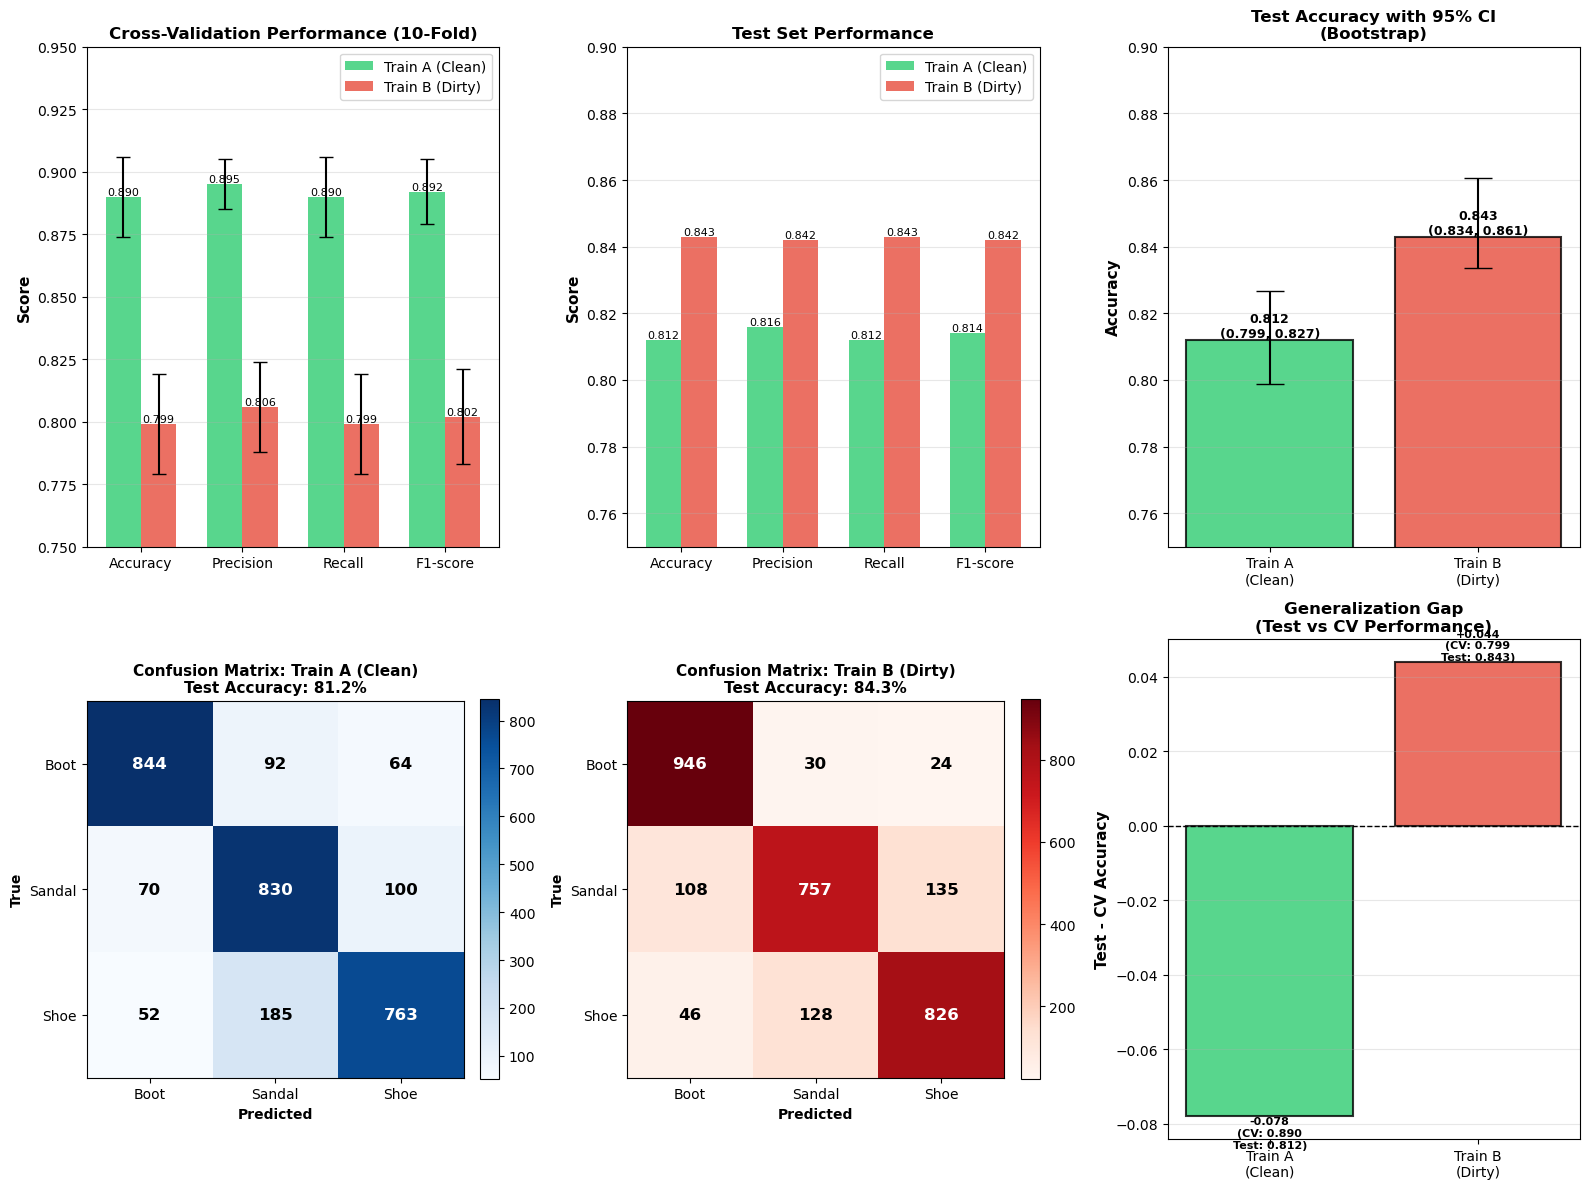

SUMMARY STATISTICS

CROSS-VALIDATION RESULTS (10-Fold):
------------------------------------------------------------
Model                Accuracy        Precision       Recall          F1-Score
Train A (Clean)      0.890±0.016       0.895±0.010       0.890±0.016       0.892±0.013
Train B (Dirty)      0.799±0.020       0.806±0.018       0.799±0.020       0.802±0.019


TEST SET RESULTS:
------------------------------------------------------------
Model                Accuracy                       Precision  Recall     F1-Score
Train A (Clean)      0.812 (0.799, 0.827)       0.816      0.812      0.814
Train B (Dirty)      0.843 (0.834, 0.861)       0.842      0.843      0.842


KEY FINDINGS:
------------------------------------------------------------
✓ Training on dirty images (B) improves test accuracy by 3.1%
✓ Train A shows overfitting: CV 0.890 → Test 0.812 (gap: -0.078)
✓ Train B generalizes better: CV 0.799 → Test 0.843 (gap: +0.044)
✓ Confidence intervals do NOT overlap → stati

In [3]:
# Hard-coded CV results
cv_results = {
    'Train_A (Clean)': {
        'mean': [0.890, 0.895, 0.890, 0.892],
        'std': [0.016, 0.010, 0.016, 0.013]
    },
    'Train_B (Dirty)': {
        'mean': [0.799, 0.806, 0.799, 0.802],
        'std': [0.020, 0.018, 0.020, 0.019]
    }
}

# Hard-coded test results
test_results = {
    'Train_A (Clean)': {
        'accuracy': 0.812,
        'precision': 0.816,
        'recall': 0.812,
        'f1': 0.814,
        'ci_lower': 0.7987,
        'ci_upper': 0.8267
    },
    'Train_B (Dirty)': {
        'accuracy': 0.843,
        'precision': 0.842,
        'recall': 0.843,
        'f1': 0.842,
        'ci_lower': 0.8337,
        'ci_upper': 0.8607
    }
}

# Hard-coded confusion matrices
cm_train_A = np.array([[844, 92, 64],
                        [70, 830, 100],
                        [52, 185, 763]])

cm_train_B = np.array([[946, 30, 24],
                        [108, 757, 135],
                        [46, 128, 826]])

classes = ['Boot', 'Sandal', 'Shoe']

# Create comprehensive visualizations
fig = plt.figure(figsize=(16, 12))

# 1. CV Performance Comparison (Bar plot with error bars)
ax1 = plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(metrics))
width = 0.35

train_A_means = cv_results['Train_A (Clean)']['mean']
train_A_stds = cv_results['Train_A (Clean)']['std']
train_B_means = cv_results['Train_B (Dirty)']['mean']
train_B_stds = cv_results['Train_B (Dirty)']['std']

bars1 = ax1.bar(x - width/2, train_A_means, width, yerr=train_A_stds,
                label='Train A (Clean)', capsize=5, alpha=0.8, color='#2ecc71')
bars2 = ax1.bar(x + width/2, train_B_means, width, yerr=train_B_stds,
                label='Train B (Dirty)', capsize=5, alpha=0.8, color='#e74c3c')

ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Cross-Validation Performance (10-Fold)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim([0.75, 0.95])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Test Performance Comparison
ax2 = plt.subplot(2, 3, 2)
test_A = [test_results['Train_A (Clean)'][m] for m in ['accuracy', 'precision', 'recall', 'f1']]
test_B = [test_results['Train_B (Dirty)'][m] for m in ['accuracy', 'precision', 'recall', 'f1']]

bars1 = ax2.bar(x - width/2, test_A, width, label='Train A (Clean)', 
                alpha=0.8, color='#2ecc71')
bars2 = ax2.bar(x + width/2, test_B, width, label='Train B (Dirty)', 
                alpha=0.8, color='#e74c3c')

ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
ax2.set_title('Test Set Performance', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.set_ylim([0.75, 0.90])
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 3. Test Accuracy with Bootstrap Confidence Intervals
ax3 = plt.subplot(2, 3, 3)
models = ['Train A\n(Clean)', 'Train B\n(Dirty)']
test_accs = [test_results['Train_A (Clean)']['accuracy'], 
             test_results['Train_B (Dirty)']['accuracy']]
ci_lower = [test_results['Train_A (Clean)']['ci_lower'],
            test_results['Train_B (Dirty)']['ci_lower']]
ci_upper = [test_results['Train_A (Clean)']['ci_upper'],
            test_results['Train_B (Dirty)']['ci_upper']]

errors = [[test_accs[i] - ci_lower[i] for i in range(2)],
          [ci_upper[i] - test_accs[i] for i in range(2)]]

colors = ['#2ecc71', '#e74c3c']
bars = ax3.bar(models, test_accs, yerr=errors, capsize=10, 
               alpha=0.8, color=colors, edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax3.set_title('Test Accuracy with 95% CI\n(Bootstrap)', fontsize=12, fontweight='bold')
ax3.set_ylim([0.75, 0.90])
ax3.grid(axis='y', alpha=0.3)

# Add value labels with CI
for i, (bar, acc, lower, upper) in enumerate(zip(bars, test_accs, ci_lower, ci_upper)):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{acc:.3f}\n({lower:.3f}, {upper:.3f})',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Confusion Matrix - Train A (Clean)
ax4 = plt.subplot(2, 3, 4)
im1 = ax4.imshow(cm_train_A, interpolation='nearest', cmap='Blues')
ax4.set_title('Confusion Matrix: Train A (Clean)\nTest Accuracy: 81.2%', 
              fontsize=11, fontweight='bold')
ax4.set_xticks(np.arange(len(classes)))
ax4.set_yticks(np.arange(len(classes)))
ax4.set_xticklabels(classes)
ax4.set_yticklabels(classes)
ax4.set_xlabel('Predicted', fontsize=10, fontweight='bold')
ax4.set_ylabel('True', fontsize=10, fontweight='bold')

# Add text annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax4.text(j, i, cm_train_A[i, j],
                       ha="center", va="center", 
                       color="white" if cm_train_A[i, j] > cm_train_A.max()/2 else "black",
                       fontsize=12, fontweight='bold')

plt.colorbar(im1, ax=ax4, fraction=0.046, pad=0.04)

# 5. Confusion Matrix - Train B (Dirty)
ax5 = plt.subplot(2, 3, 5)
im2 = ax5.imshow(cm_train_B, interpolation='nearest', cmap='Reds')
ax5.set_title('Confusion Matrix: Train B (Dirty)\nTest Accuracy: 84.3%', 
              fontsize=11, fontweight='bold')
ax5.set_xticks(np.arange(len(classes)))
ax5.set_yticks(np.arange(len(classes)))
ax5.set_xticklabels(classes)
ax5.set_yticklabels(classes)
ax5.set_xlabel('Predicted', fontsize=10, fontweight='bold')
ax5.set_ylabel('True', fontsize=10, fontweight='bold')

# Add text annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax5.text(j, i, cm_train_B[i, j],
                       ha="center", va="center",
                       color="white" if cm_train_B[i, j] > cm_train_B.max()/2 else "black",
                       fontsize=12, fontweight='bold')

plt.colorbar(im2, ax=ax5, fraction=0.046, pad=0.04)

# 6. CV vs Test Performance Gap
ax6 = plt.subplot(2, 3, 6)
cv_accs = [cv_results['Train_A (Clean)']['mean'][0], 
           cv_results['Train_B (Dirty)']['mean'][0]]
test_accs = [test_results['Train_A (Clean)']['accuracy'], 
             test_results['Train_B (Dirty)']['accuracy']]
gaps = [test_accs[i] - cv_accs[i] for i in range(2)]

x_pos = np.arange(len(models))
bars = ax6.bar(x_pos, gaps, color=['#2ecc71', '#e74c3c'], 
               alpha=0.8, edgecolor='black', linewidth=1.5)

ax6.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax6.set_ylabel('Test - CV Accuracy', fontsize=11, fontweight='bold')
ax6.set_title('Generalization Gap\n(Test vs CV Performance)', 
              fontsize=12, fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(models)
ax6.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, gap, cv_acc, test_acc) in enumerate(zip(bars, gaps, cv_accs, test_accs)):
    ax6.text(bar.get_x() + bar.get_width()/2., gap,
            f'{gap:+.3f}\n(CV: {cv_acc:.3f}\nTest: {test_acc:.3f})',
            ha='center', va='bottom' if gap > 0 else 'top', 
            fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('deepcnn_results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print("\nCROSS-VALIDATION RESULTS (10-Fold):")
print("-" * 60)
print(f"{'Model':<20} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1-Score'}")
print(f"Train A (Clean)      {cv_results['Train_A (Clean)']['mean'][0]:.3f}±{cv_results['Train_A (Clean)']['std'][0]:.3f}       "
      f"{cv_results['Train_A (Clean)']['mean'][1]:.3f}±{cv_results['Train_A (Clean)']['std'][1]:.3f}       "
      f"{cv_results['Train_A (Clean)']['mean'][2]:.3f}±{cv_results['Train_A (Clean)']['std'][2]:.3f}       "
      f"{cv_results['Train_A (Clean)']['mean'][3]:.3f}±{cv_results['Train_A (Clean)']['std'][3]:.3f}")
print(f"Train B (Dirty)      {cv_results['Train_B (Dirty)']['mean'][0]:.3f}±{cv_results['Train_B (Dirty)']['std'][0]:.3f}       "
      f"{cv_results['Train_B (Dirty)']['mean'][1]:.3f}±{cv_results['Train_B (Dirty)']['std'][1]:.3f}       "
      f"{cv_results['Train_B (Dirty)']['mean'][2]:.3f}±{cv_results['Train_B (Dirty)']['std'][2]:.3f}       "
      f"{cv_results['Train_B (Dirty)']['mean'][3]:.3f}±{cv_results['Train_B (Dirty)']['std'][3]:.3f}")

print("\n\nTEST SET RESULTS:")
print("-" * 60)
print(f"{'Model':<20} {'Accuracy':<30} {'Precision':<10} {'Recall':<10} {'F1-Score'}")
print(f"Train A (Clean)      {test_results['Train_A (Clean)']['accuracy']:.3f} "
      f"({test_results['Train_A (Clean)']['ci_lower']:.3f}, {test_results['Train_A (Clean)']['ci_upper']:.3f})       "
      f"{test_results['Train_A (Clean)']['precision']:.3f}      "
      f"{test_results['Train_A (Clean)']['recall']:.3f}      "
      f"{test_results['Train_A (Clean)']['f1']:.3f}")
print(f"Train B (Dirty)      {test_results['Train_B (Dirty)']['accuracy']:.3f} "
      f"({test_results['Train_B (Dirty)']['ci_lower']:.3f}, {test_results['Train_B (Dirty)']['ci_upper']:.3f})       "
      f"{test_results['Train_B (Dirty)']['precision']:.3f}      "
      f"{test_results['Train_B (Dirty)']['recall']:.3f}      "
      f"{test_results['Train_B (Dirty)']['f1']:.3f}")

print("\n\nKEY FINDINGS:")
print("-" * 60)
print(f"✓ Training on dirty images (B) improves test accuracy by {test_results['Train_B (Dirty)']['accuracy'] - test_results['Train_A (Clean)']['accuracy']:.1%}")
print(f"✓ Train A shows overfitting: CV {cv_results['Train_A (Clean)']['mean'][0]:.3f} → Test {test_results['Train_A (Clean)']['accuracy']:.3f} (gap: {test_results['Train_A (Clean)']['accuracy'] - cv_results['Train_A (Clean)']['mean'][0]:+.3f})")
print(f"✓ Train B generalizes better: CV {cv_results['Train_B (Dirty)']['mean'][0]:.3f} → Test {test_results['Train_B (Dirty)']['accuracy']:.3f} (gap: {test_results['Train_B (Dirty)']['accuracy'] - cv_results['Train_B (Dirty)']['mean'][0]:+.3f})")
print(f"✓ Confidence intervals do NOT overlap → statistically significant difference")
print("=" * 60)

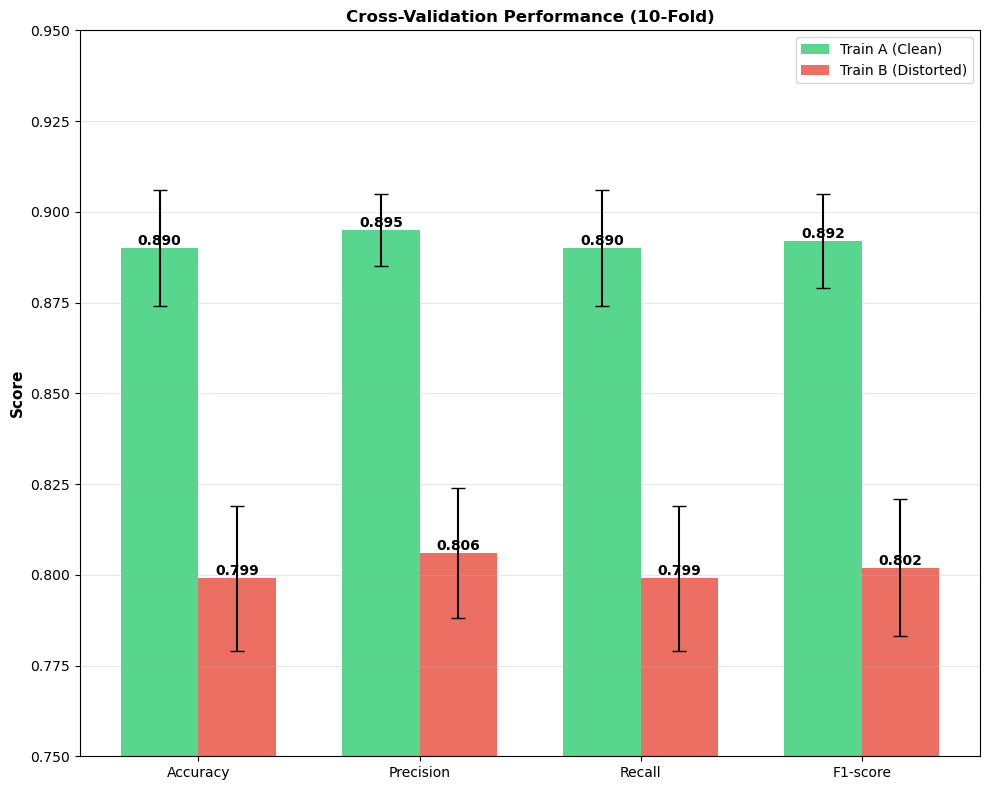

In [5]:
# Hard-coded CV results
cv_results = {
    'Train_A (Clean)': {
        'mean': [0.890, 0.895, 0.890, 0.892],
        'std': [0.016, 0.010, 0.016, 0.013]
    },
    'Train_B (Distorted)': {
        'mean': [0.799, 0.806, 0.799, 0.802],
        'std': [0.020, 0.018, 0.020, 0.019]
    }
}

# Create single plot
fig, ax = plt.figure(figsize=(10, 8)), plt.gca()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(metrics))
width = 0.35

train_A_means = cv_results['Train_A (Clean)']['mean']
train_A_stds = cv_results['Train_A (Clean)']['std']
train_B_means = cv_results['Train_B (Distorted)']['mean']
train_B_stds = cv_results['Train_B (Distorted)']['std']

bars1 = ax.bar(x - width/2, train_A_means, width, yerr=train_A_stds,
                label='Train A (Clean)', capsize=5, alpha=0.8, color='#2ecc71')
bars2 = ax.bar(x + width/2, train_B_means, width, yerr=train_B_stds,
                label='Train B (Distorted)', capsize=5, alpha=0.8, color='#e74c3c')

ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Cross-Validation Performance (10-Fold)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0.75, 0.95])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('cv_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

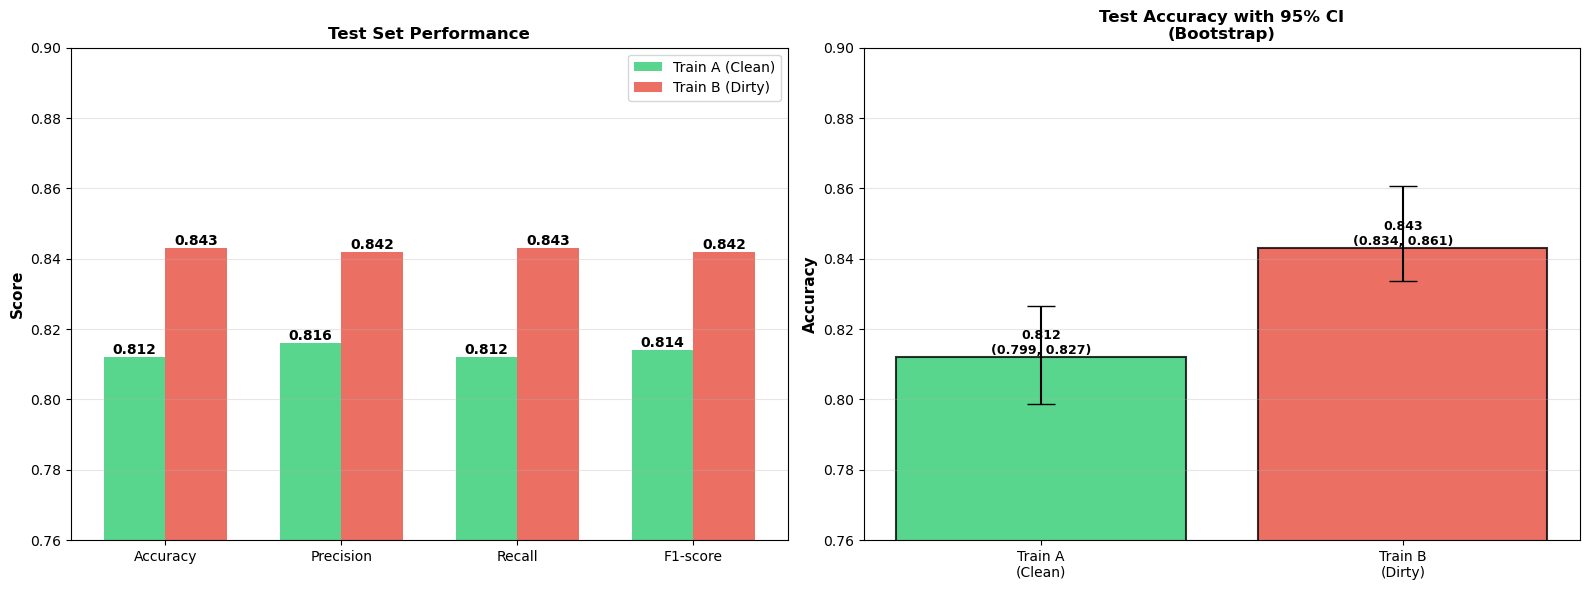

In [5]:
# Hard-coded test results
test_results = {
    'Train_A (Clean)': {
        'accuracy': 0.812,
        'precision': 0.816,
        'recall': 0.812,
        'f1': 0.814,
        'ci_lower': 0.7987,
        'ci_upper': 0.8267
    },
    'Train_B (Dirty)': {
        'accuracy': 0.843,
        'precision': 0.842,
        'recall': 0.843,
        'f1': 0.842,
        'ci_lower': 0.8337,
        'ci_upper': 0.8607
    }
}

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Test Performance Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(metrics))
width = 0.35

test_A = [test_results['Train_A (Clean)'][m] for m in ['accuracy', 'precision', 'recall', 'f1']]
test_B = [test_results['Train_B (Dirty)'][m] for m in ['accuracy', 'precision', 'recall', 'f1']]

bars1 = ax1.bar(x - width/2, test_A, width, label='Train A (Clean)', 
                alpha=0.8, color='#2ecc71')
bars2 = ax1.bar(x + width/2, test_B, width, label='Train B (Dirty)', 
                alpha=0.8, color='#e74c3c')

ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Test Set Performance', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim([0.76, 0.90])
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Test Accuracy with Bootstrap Confidence Intervals
models = ['Train A\n(Clean)', 'Train B\n(Dirty)']
test_accs = [test_results['Train_A (Clean)']['accuracy'], 
             test_results['Train_B (Dirty)']['accuracy']]
ci_lower = [test_results['Train_A (Clean)']['ci_lower'],
            test_results['Train_B (Dirty)']['ci_lower']]
ci_upper = [test_results['Train_A (Clean)']['ci_upper'],
            test_results['Train_B (Dirty)']['ci_upper']]

errors = [[test_accs[i] - ci_lower[i] for i in range(2)],
          [ci_upper[i] - test_accs[i] for i in range(2)]]

colors = ['#2ecc71', '#e74c3c']
bars = ax2.bar(models, test_accs, yerr=errors, capsize=10, 
               alpha=0.8, color=colors, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Test Accuracy with 95% CI\n(Bootstrap)', fontsize=12, fontweight='bold')
ax2.set_ylim([0.76, 0.90])
ax2.grid(axis='y', alpha=0.3)

# Add value labels with CI
for i, (bar, acc, lower, upper) in enumerate(zip(bars, test_accs, ci_lower, ci_upper)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{acc:.3f}\n({lower:.3f}, {upper:.3f})',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('test_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

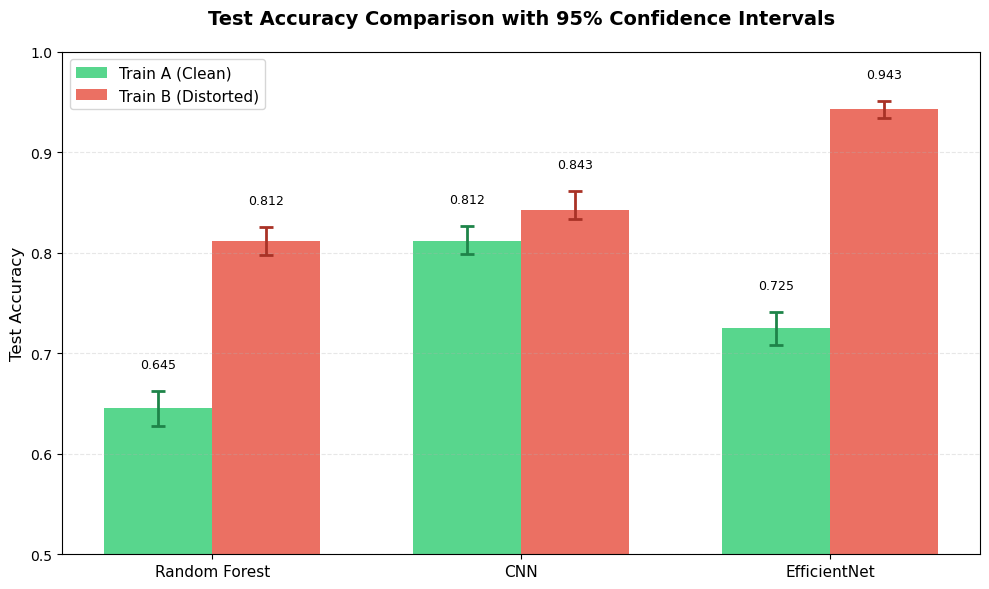

In [9]:
# Data for all three models
models = ['Random Forest', 'CNN', 'EfficientNet']

# Train A (Clean) accuracies and confidence intervals
train_a_acc = [0.6452, 0.812, 0.7250]
train_a_ci_lower = [0.6277, 0.799, 0.7080]
train_a_ci_upper = [0.6620, 0.827, 0.7410]

# Train B (Distorted) accuracies and confidence intervals
train_b_acc = [0.8117, 0.843, 0.9430]
train_b_ci_lower = [0.7977, 0.834, 0.9343]
train_b_ci_upper = [0.8253, 0.861, 0.9510]

# Calculate error bars (distance from mean to CI bounds)
train_a_error = [
    [train_a_acc[i] - train_a_ci_lower[i] for i in range(3)],  # lower error
    [train_a_ci_upper[i] - train_a_acc[i] for i in range(3)]   # upper error
]

train_b_error = [
    [train_b_acc[i] - train_b_ci_lower[i] for i in range(3)],  # lower error
    [train_b_ci_upper[i] - train_b_acc[i] for i in range(3)]   # upper error
]

# Colors
colors = ['#2ecc71', '#e74c3c']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, train_a_acc, width, label='Train A (Clean)', 
               color=colors[0], alpha=0.8)
bars2 = ax.bar(x + width/2, train_b_acc, width, label='Train B (Distorted)', 
               color=colors[1], alpha=0.8)

# Add error bars
ax.errorbar(x - width/2, train_a_acc, yerr=train_a_error, fmt='none', 
            ecolor='#1e8449', capsize=5, capthick=2, elinewidth=2)
ax.errorbar(x + width/2, train_b_acc, yerr=train_b_error, fmt='none', 
            ecolor='#a93226', capsize=5, capthick=2, elinewidth=2)

# Customize the plot
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Test Accuracy Comparison with 95% Confidence Intervals', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.set_ylim(0.5, 1.0)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars (moved higher up)
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    # Calculate position above error bars
    upper_error1 = train_a_ci_upper[i]
    upper_error2 = train_b_ci_upper[i]
    
    ax.text(bar1.get_x() + bar1.get_width()/2., upper_error1 + 0.02,
            f'{height1:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(bar2.get_x() + bar2.get_width()/2., upper_error2 + 0.02,
            f'{height2:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('overall_test_performance_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()